In [27]:
import pandas as pd
import h5py
from Bio import SeqIO
from copy import deepcopy 
import numpy as np
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.decomposition import PCA
import pickle
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,RocCurveDisplay
from matplotlib.colors import to_hex

def load_embedding(file_name,keyset=None):
    f = h5py.File(file_name)
    Xg = []
    if keyset is None:
        gene_names = list(f.keys())
    else:
        gene_names = keyset
        
    for key in gene_names:
        Xg.append(f[key][()])
    f.close()
    Xg = pd.DataFrame(np.asmatrix(Xg),index=gene_names)
    return Xg,gene_names



def load_keys(file_name):
    f = h5py.File(file_name)
    gene_names = list(f.keys())
    f.close()
    return gene_names

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

In [29]:
from cbtk.stats import run_pca

In [30]:
#file = "lrmodel.l1reg.embedding2mow.pkl"
#file = "lrmodel.l2reg.embedding2mow.10Jan2023.pkl"
file = "lrmodel.l1reg.embedding2mow.18Feb2023.pkl"

with open(file,"rb") as handle:
    model = pickle.load(handle)

/Users/joshuagoldford/opt/miniconda3/envs/informatics.p38/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
#gnt = pd.read_csv("../data/sequenceTable.pterinDomains.gtdb.22Dec2022.csv",index_col=0)
gnt = pd.read_csv("../data/pterin-binding-gtdb/sequenceTable.csv",index_col=0)
gnt['gene name'] = gnt['gene name'].apply(lambda x: x.replace('.',"_"))
aor_seqs = gnt[gnt.KO.isin(['K03738'])]['gene name'].tolist()

In [32]:
gnt

,gene name,KO,genome
11844,JACMQD010000003_1_4,K11177,GB_GCA_014377155.1
23143,JACMQD010000004_1_12,K11177,GB_GCA_014377155.1
103317,JACMQD010000147_1_23,K07303,GB_GCA_014377155.1
106467,JACMQD010000156_1_13,K07303,GB_GCA_014377155.1
137858,JACMQD010000230_1_5,K00370,GB_GCA_014377155.1
...,...,...,...
13814,NZ_LKKK01000001_1_324,K07303,RS_GCF_001446935.1
8259,NZ_JNWO01000001_1_180,K03520,RS_GCF_000716435.1
25144,NZ_JNWO01000001_1_510,K03520,RS_GCF_000716435.1
100964,NZ_JNWO01000005_1_18,K12528,RS_GCF_000716435.1


In [33]:
f = "../data/gtdb.pterinSeqs.embed.22Dec2022.h5"
genekeys = load_keys(f)
gkeymap = pd.DataFrame({'gene':[x.split(" ")[0] for x in genekeys],"gkey":genekeys})
gkeys = gkeymap[gkeymap.gene.isin(aor_seqs)].gkey.tolist()
pterinEmbeddingGTDB,gns = load_embedding(f,keyset=gkeys)

In [34]:
pterinEmbeddingGTDB.index = [x.split(' ')[0] for x in pterinEmbeddingGTDB.index.tolist()]
pca_res = run_pca(pterinEmbeddingGTDB, n_components=2, normalize=False)
pdf = pca_res["pdf"] 
pdf = pdf.join(gnt.set_index("gene name"))

In [59]:

metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
# get ncbi taxa ids for gtdb genomes
archaea = pd.read_csv("../data/taxa/ar53_metadata_r207.tsv",sep='\t')
archaea = archaea[['accession','ncbi_taxid']]

bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')
bacteria = bacteria[['accession','ncbi_taxid']]

archaea['domain'] = "Archaea"
bacteria['domain'] = "Bacteria"

gtdb_to_ncbi = pd.concat([archaea,bacteria],axis=0)
pdf =  pdf.reset_index().set_index("genome").join(gtdb_to_ncbi.set_index("accession"))

/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_4617/1732327538.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_4617/1732327538.py:6: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')


<Axes: xlabel='PC1 (28.02%)', ylabel='PC2 (12.61%)'>

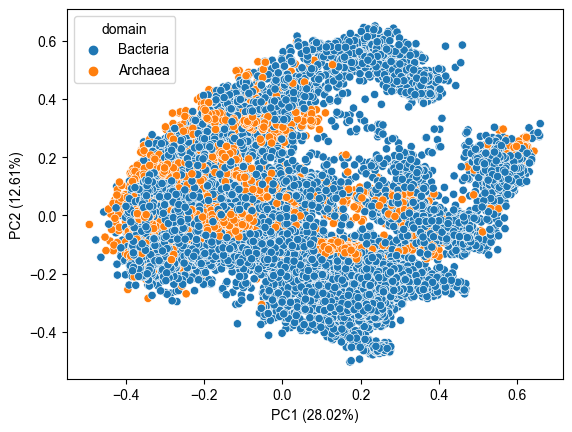

In [60]:
sns.scatterplot(x="PC1 (28.02%)",y="PC2 (12.61%)",data=pdf,hue="domain")

In [43]:
kmeans = KMeans(n_clusters=2).fit(pterinEmbeddingGTDB.values)
kmeans_labels = pd.DataFrame(kmeans.labels_,index=pterinEmbeddingGTDB.index,columns = ["predict"])

/Users/joshuagoldford/opt/miniconda3/envs/informatics.p38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
kmeans_labels = kmeans_labels.join(gnt.set_index("gene name"))
kmeans_labels =  kmeans_labels.reset_index().set_index("genome").join(gtdb_to_ncbi.set_index("accession"))

In [50]:
pd.crosstab(kmeans_labels["predict"],kmeans_labels["domain"])

domain,Archaea,Bacteria
predict,,
0,4357,9678
1,950,8323


In [35]:

predictions_aorGTDB= model.predict(pterinEmbeddingGTDB)
predictions_aorGTDB = pd.DataFrame({'predict':predictions_aorGTDB},index=pterinEmbeddingGTDB.index)
predictions_aorGTDB['gene_id']= [x.split(' ')[0] for x in gns]
predictions_aorGTDB.set_index("gene_id",inplace=True)

In [36]:
aorGTDB = predictions_aorGTDB.join(gnt[gnt.KO.isin(['K03738'])].set_index("gene name"))

In [38]:
aorGTDB.to_csv("aor_predictions.27Apr2023.csv")

In [43]:
aorGTDB_mo = aorGTDB[aorGTDB.predict.isin(["Mo"])]

In [97]:
pca_res = run_pca(pterinEmbeddingGTDB, n_components=2, normalize=False)
pdf = pca_res["pdf"] 
labels = list(pca_res["pdf"])
pdf = pdf.join(gnt.set_index("gene name"))
pdf = pdf.join(aorGTDB[["predict"]])

In [98]:
pdf

,PC1 (28.02%),PC2 (12.61%),KO,genome,predict
ADZZ01000072_1_3,0.170209,-0.256137,K03738,GB_GCA_000179315.1,W
ADZZ01000330_1_31,0.535517,0.138073,K03738,GB_GCA_000179315.1,W
ADZZ01000712_1_1,0.552976,0.167684,K03738,GB_GCA_000179315.1,W
AGIG01000028_1_204,0.154342,-0.309074,K03738,GB_GCA_000227525.2,W
AKCV02000026_1_331,0.210884,-0.340283,K03738,GB_GCA_000272025.2,W
...,...,...,...,...,...
WYEN01000030_1_2,-0.305317,0.091070,K03738,GB_GCA_009903825.1,W
WYEN01000038_1_6,-0.188357,0.205924,K03738,GB_GCA_009903825.1,W
WYEN01000096_1_4,-0.261354,0.010808,K03738,GB_GCA_009903825.1,W
WYEN01000106_1_2,0.228700,0.085898,K03738,GB_GCA_009903825.1,W


<Axes: xlabel='PC1 (28.02%)', ylabel='PC2 (12.61%)'>

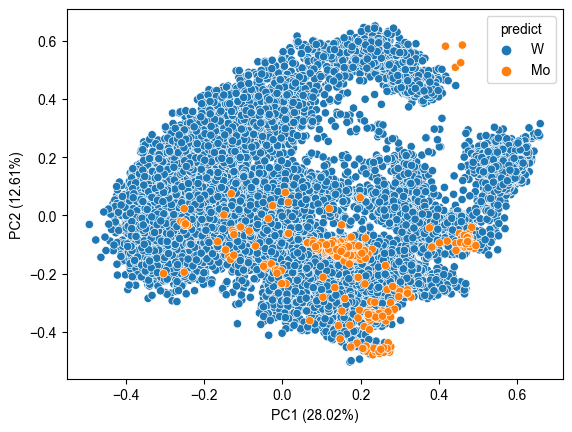

In [101]:
sns.scatterplot(x=labels[0],y=labels[1],data=pdf.sort_values("predict",ascending=False),hue="predict")

In [45]:

metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
# get ncbi taxa ids for gtdb genomes
archaea = pd.read_csv("../data/taxa/ar53_metadata_r207.tsv",sep='\t')
bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')
tax = pd.concat([bacteria,archaea],axis=0).set_index("accession")

/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_26617/2055548340.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_26617/2055548340.py:4: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')


In [58]:
aorGTDB_2 = aorGTDB_mo.reset_index().set_index("genome").join(tax).reset_index()

In [64]:
aorGTDB_2.columns = ["genome"] + list(aorGTDB_2)[1:]

,index,gene_id,predict,KO,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_000336895.1,AOLX01000025_1_36,Mo,K03738,58,99.92,0.40,395,f__Halobacteriaceae (UID85),250,...,1219,2241,0,100,AOLX01000028.1.1221,Archaea;Halobacterota;Halobacteria;Halobactera...,0,20,67,0
1,GB_GCA_000496175.1,KI543167_1_470,Mo,K03738,0,95.51,2.79,417,f__Halobacteriaceae (UID96),263,...,1457,2669,0,99.725,AYLI01000329.16498.17954,Archaea;Halobacterota;Halobacteria;Halobactera...,216438,17,38,0
2,GB_GCA_000496195.1,KI543183_1_122,Mo,K03738,0,85.20,0.20,417,f__Halobacteriaceae (UID96),263,...,1459,2695,0,100,AYLJ01000015.6614.8072,Archaea;Halobacterota;Halobacteria;Halobactera...,201709,17,37,0
3,GB_GCA_000690595.2,JHUT02000005_1_27,Mo,K03738,11,99.57,0.38,417,f__Halobacteriaceae (UID96),263,...,1471,2695,0,99.728,KY349160.1.1473,Archaea;Halobacterota;Halobacteria;Halobactera...,595,19,48,0
4,GB_GCA_000720375.1,JOAA01000023_1_33,Mo,K03738,0,99.47,3.85,495,o__Actinomycetales (UID2012),282,...,1319,2403,0,99.545,CP012752.3312331.3313855,Bacteria;Actinobacteriota;Actinobacteria;Pseud...,0,20,66,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,RS_GCF_900156475.1,NZ_FTNR01000013_1_21,Mo,K03738,0,99.24,0.86,417,f__Halobacteriaceae (UID96),263,...,852,1515,0,98.826,AB046927.1.1474,Archaea;Halobacterota;Halobacteria;Halobactera...,837,19,49,0
384,RS_GCF_900167125.1,NZ_FUYC01000002_1_117,Mo,K03738,0,100.00,0.00,284,c__Deltaproteobacteria (UID3218),169,...,1525,2717,0,98.82,AJ548465.1.1525,Bacteria;Desulfobacterota;Desulfovibrionia;Des...,0,19,52,1
385,RS_GCF_900176515.1,NZ_FWXV01000012_1_188,Mo,K03738,0,99.11,3.93,495,o__Actinomycetales (UID2012),282,...,1484,2741,0,100,AJ311174.1.1484,Bacteria;Actinobacteriota;Actinobacteria;Pseud...,2554,20,69,1
386,RS_GCF_900182635.1,NZ_FXTD01000010_1_77,Mo,K03738,0,98.92,0.00,417,f__Halobacteriaceae (UID96),263,...,1469,2713,0,100,AB576123.1.1471,Archaea;Halobacterota;Halobacteria;Halobactera...,0,20,47,0


In [71]:
aorGTDB_2.set_index("gene_id").to_csv("Mo_dependent_aor_predictions.27Apr2023.csv")

In [5]:

metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
# get ncbi taxa ids for gtdb genomes
archaea = pd.read_csv("../data/taxa/ar53_metadata_r207.tsv",sep='\t')
archaea = archaea[['accession','ncbi_taxid']]

bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')
bacteria = bacteria[['accession','ncbi_taxid']]

archaea['domain'] = "Archaea"
bacteria['domain'] = "Bacteria"

gtdb_to_ncbi = pd.concat([archaea,bacteria],axis=0)

aorGTDB_ncbi = aorGTDB.reset_index().set_index("genome").join(gtdb_to_ncbi.set_index("accession"))

aorGTDB_ncbi = aorGTDB_ncbi.reset_index().set_index('ncbi_taxid').join(metadata.set_index("NCBI_TAXONOMY_ID"))
aorGTDB_ncbi = aorGTDB_ncbi.drop_duplicates()


possible = ['Obligate aerobe', 'Aerobe',"Anaerobe",'Obligate anaerobe']
aorGTDB_ncbi_sub = aorGTDB_ncbi[aorGTDB_ncbi.OXYGEN_REQUIREMENT.isin(possible)]

#aerobe = ['Obligate aerobe', 'Aerobe',"Microaerophilic","Facultative","Facultative anaerobe"]
#df2['o2_tol']= df2["OXYGEN_REQUIREMENT"].isin(aerobe)
aerobe = ['Obligate aerobe', 'Aerobe']
aorGTDB_ncbi_sub['o2_tol']= aorGTDB_ncbi_sub["OXYGEN_REQUIREMENT"].isin(aerobe)

glabel = {}
glabel[True] = 'Aerobe'
glabel[False] = 'Anaerobe'

aorGTDB_ncbi_sub['physiology'] = aorGTDB_ncbi_sub["o2_tol"].apply(lambda x: glabel[x])



/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_3933/4095429787.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../data/taxa/Mark_Westoby_Organism_Metadata_Export_02152018.txt",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_3933/4095429787.py:6: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')
/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_3933/4095429787.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aorGTDB_ncbi_sub['o2_tol']= aorGTDB_ncbi_sub["OXYGEN_REQUIREMENT"].isin(ae

In [23]:
aorGTDB_ncbi_sub.groupby("gene_id").count().sort_values("KO",ascending=False).iloc[0:15]

,level_0,index,predict,KO,domain,GOLD_ORGANISM_ID,ORGANISM_NAME,GENUS,SPECIES,STRAIN,...,TEMPERATURE_RANGE,BIOTIC_RELATIONSHIP,SYMBIOTIC_RELATIONSHIP,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM,o2_tol,physiology
gene_id,,,,,,,,,,,,,,,,,,,,,
JAENWM010000028_1_41,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAAYTS010000305_1_12,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAAYTS010000305_1_22,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAAZGI010000234_1_4,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAGBNL010000154_1_18,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAGXRV010000029_1_2,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAGXRV010000083_1_16,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAGXRV010000074_1_79,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
JAENWM010000028_1_36,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13


In [31]:
aorGTDB_ncbi_sub

,level_0,index,gene_id,predict,KO,domain,GOLD_ORGANISM_ID,ORGANISM_NAME,GENUS,SPECIES,...,TEMPERATURE_RANGE,BIOTIC_RELATIONSHIP,SYMBIOTIC_RELATIONSHIP,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM,o2_tol,physiology
24,RS_GCF_016406305.1,16049,NZ_CP066369_1_1113,W,K03738,Bacteria,6538.0,Shewanella putrefaciens W3-6-1,Shewanella,Shewanella putrefaciens,...,Mesophile,Free living,(null),Host-associated,(null),(null),(null),(null),False,Anaerobe
24,RS_GCF_016406325.1,16050,NZ_CP066370_1_1106,W,K03738,Bacteria,6538.0,Shewanella putrefaciens W3-6-1,Shewanella,Shewanella putrefaciens,...,Mesophile,Free living,(null),Host-associated,(null),(null),(null),(null),False,Anaerobe
52,RS_GCF_001189295.1,15595,NZ_CP012159_1_5949,W,K03738,Bacteria,4383.0,Chondromyces crocatus KYC2823,Chondromyces,Chondromyces crocatus,...,(null),Free living,(null),Environmental,Terrestrial,Soil,Unclassified,Unclassified,True,Aerobe
274,GB_GCA_002355995.1,22,AP017920_1_1018,W,K03738,Bacteria,2120.0,Thermus thermophilus,Thermus,Thermus thermophilus,...,Thermophile,Free living,(null),Environmental,Aquatic,Marine,Hydrothermal vents,Unclassified,True,Aerobe
274,GB_GCA_002355995.1,23,AP017920_1_1216,W,K03738,Bacteria,2120.0,Thermus thermophilus,Thermus,Thermus thermophilus,...,Thermophile,Free living,(null),Environmental,Aquatic,Marine,Hydrothermal vents,Unclassified,True,Aerobe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750597,RS_GCF_003751635.1,17932,NZ_RJVI01000002_1_645,W,K03738,Bacteria,402678.0,Inmirania thermothiophila DSM 100275,Inmirania,Inmirania thermothiophila,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe
1773489,RS_GCF_004341725.1,18006,NZ_SLZW01000003_1_102,W,K03738,Bacteria,402712.0,Varunaivibrio sulfuroxidans DSM 101688,Varunaivibrio,Varunaivibrio sulfuroxidans,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe
1835254,RS_GCF_000973625.1,15524,NZ_CP007501_1_181,W,K03738,Bacteria,9907.0,Polynucleobacter duraquae MWH-MoK4,Polynucleobacter,Polynucleobacter duraquae,...,Mesophile,Free living,(null),Environmental,Aquatic,Freshwater,Lentic,Unclassified,True,Aerobe
1894989,RS_GCF_003815015.1,17936,NZ_RKRE01000001_1_643,W,K03738,Bacteria,402742.0,Thermodesulfitimonas autotrophica DSM 102936,Thermodesulfitimonas,Thermodesulfitimonas autotrophica,...,(null),(null),(null),(null),(null),(null),(null),(null),False,Anaerobe


In [30]:
aorGTDB_ncbi_sub[aorGTDB_ncbi_sub.gene_id.isin(["JAGXRV010000074_1_79"])]

,level_0,index,gene_id,predict,KO,domain,GOLD_ORGANISM_ID,ORGANISM_NAME,GENUS,SPECIES,...,TEMPERATURE_RANGE,BIOTIC_RELATIONSHIP,SYMBIOTIC_RELATIONSHIP,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM,o2_tol,physiology
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,4047.0,Clostridium sp. A1-86,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),Host-associated,Human,Digestive system,Large intestine,Fecal,False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,597.0,Clostridium sp. ATCC BAA-826,Clostridium,Clostridium sp. ATCC BAA-826,...,Mesophile,Free living,(null),Host-associated,Human,Digestive system,Large intestine,Fecal,False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3570.0,Clostridium sp. 16,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3574.0,Clostridium sp.20,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3572.0,Clostridium sp. 18,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3573.0,Clostridium sp. 19,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,5565.0,Clostridium sp.,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),Host-associated,Animal,Skin,Unclassified,Unclassified,False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,2030.0,Clostridium sp.,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),Host-associated,Unclassified,Unclassified,Unclassified,Unclassified,False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3568.0,Clostridium sp. 14,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe
1506,GB_GCA_018335695.1,11849,JAGXRV010000074_1_79,W,K03738,Bacteria,3569.0,Clostridium sp. 15,Clostridium,Clostridium sp.,...,Mesophile,Free living,(null),(null),(null),(null),(null),(null),False,Anaerobe


In [2]:
import pandas as pd
taxon = pd.read_csv("../data/gtdb_taxonomy.csv")

In [24]:
archaea = pd.read_csv("../data/taxa/ar53_metadata_r207.tsv",sep='\t')
bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')
metadata = pd.concat([archaea,bacteria],axis=0)

/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_26617/737972981.py:2: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  bacteria = pd.read_csv("../data/taxa/bac120_metadata_r207.tsv",sep='\t')


In [3]:
aorGTDB = pd.read_csv("../data/aor/gene_cofactor_predictions.l1reg.01032023.csv")

In [7]:
b_isolates = bacteria[bacteria["ncbi_isolate"].apply(lambda x: x != "none")].accession.tolist()
a_isolates = archaea[archaea["ncbi_isolate"].apply(lambda x: x != "none")].accession.tolist()

In [103]:
#aorGTDB.to_csv("../data/aor/gene_cofactor_predictions.l1reg.01032023.csv")

In [3]:
import pandas as pd
aorGTDB = pd.read_csv("../data/aor/gene_cofactor_predictions.l1reg.01032023.csv")

In [8]:
aor_Mo = aorGTDB[aorGTDB.predict == "Mo"]

In [25]:
metadata_sub = metadata[metadata.accession.isin(aor_Mo.genome.tolist())]

In [26]:
#metadata_sub

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
88,GB_GCA_003020965.1,0,95.22,1.56,359,f__Halobacteriaceae (UID84),235,0.00,2501019,84.724932,...,288,481,2.59e-134,96.875,KT165043.1.915,Archaea;Halobacterota;Halobacteria;Halobactera...,977,17,38,0
317,RS_GCF_000336615.1,165,99.92,0.40,395,f__Halobacteriaceae (UID85),250,0.00,3643519,86.228483,...,1019,1879,0,99.902,AB605776.1.1472,Archaea;Halobacterota;Halobacteria;Halobactera...,0,20,63,0
318,RS_GCF_000336815.1,113,99.06,0.13,417,f__Halobacteriaceae (UID96),263,0.00,3457307,86.458634,...,973,1792,0,99.897,AB663381.1.1473,Archaea;Halobacterota;Halobacteria;Halobactera...,0,20,55,0
321,RS_GCF_000337675.1,143,98.53,0.40,395,f__Halobacteriaceae (UID85),250,0.00,3745053,84.796373,...,1364,2512,0,100,AOIB01000019.1209.2578,Archaea;Halobacterota;Halobacteria;Halobactera...,0,20,49,0
349,RS_GCF_004765805.1,0,98.23,2.55,359,f__Halobacteriaceae (UID84),235,100.00,3365266,85.544112,...,1469,2713,0,100,KT261642.1.1471,Archaea;Halobacterota;Halobacteria;Halobactera...,10,20,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297507,GB_GCA_903875135.1,0,92.05,0.57,570,o__Burkholderiales (UID4001),250,42.86,2525416,93.675584,...,1421,1129,0,81.351,KF741419.1.1443,Bacteria;Proteobacteria;Alphaproteobacteria;Ri...,0,14,30,0
297713,GB_GCA_903932805.1,0,96.01,1.15,155,k__Bacteria (UID1452),106,66.67,2592847,92.802696,...,none,none,none,none,none,none,0,15,31,0
303858,RS_GCF_003063665.1,0,99.97,0.50,427,o__Burkholderiales (UID4000),214,50.00,2740697,91.641235,...,1521,2758,0,99.408,CP011774.47623.49143,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,0,20,41,0
306206,RS_GCF_008065375.1,0,99.47,2.85,314,o__Actinomycetales (UID1696),189,9.09,10938595,87.972106,...,1522,2641,0,98.029,CP017717.11588363.11589894,Bacteria;Actinobacteriota;Actinobacteria;Strep...,20,20,67,3


In [9]:
isolates = aor_Mo[aor_Mo.genome.isin(a_isolates + b_isolates)].genome.tolist()

In [16]:
#a = archaea[archaea.accession.isin(isolates)]
b = bacteria[bacteria.accession.isin(isolates)]

In [21]:
#b["ncbi_isolate"].tolist()

In [22]:
#b["ncbi_isolation_source"].tolist()

In [10]:
g = aorGTDB[aorGTDB["predict"].isin(["Mo"])].genome.tolist()

In [18]:
mot = taxon[taxon["genome"].isin(g)]
mot["phyla"] = mot["taxonomy"].apply(lambda x: x.split(";")[1])

In [28]:
mot.groupby("phyla").count().sort_values("genome")

,genome,taxonomy
phyla,,
p__Desulfobacterota_C,1,1
p__Desulfobacterota_I,1,1
p__Firmicutes_B,1,1
p__Methylomirabilota,5,5
p__Acidobacteriota,6,6
p__Planctomycetota,6,6
p__Chloroflexota,8,8
p__Firmicutes_A,9,9
p__Asgardarchaeota,12,12


In [30]:
mot

,genome,taxonomy,phyla
293,RS_GCF_000025685.1,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,p__Halobacteriota
394,RS_GCF_002114285.1,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,p__Halobacteriota
631,RS_GCF_000223905.1,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,p__Halobacteriota
811,RS_GCF_000011085.1,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,p__Halobacteriota
919,RS_GCF_001488575.1,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,p__Halobacteriota
...,...,...,...
316700,GB_GCA_003220195.1,d__Bacteria;p__Methylomirabilota;c__Methylomir...,p__Methylomirabilota
316890,GB_GCA_903958915.1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria
316960,RS_GCF_000293865.2,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,p__Proteobacteria
317123,GB_GCA_014860225.1,d__Bacteria;p__Desulfobacterota;c__Desulfuromo...,p__Desulfobacterota


In [121]:
gl = aorGTDB.index.tolist()
gl = ["_".join(x.split("_")[:-2]) + "." + "_".join(x.split("_")[-2:]) for x in gl]
aorGTDB["gene"] = gl
aorGTDB["color"] = aorGTDB["predict"].apply(lambda x: cmap[x])

In [128]:
aorGTDB[["gene", "color"]].set_index("gene").to_csv("../data/aor/gene_color.K03878.csv")

In [1]:
import pandas as pd
df_tmp = pd.read_csv("../data/aor/gene_color.K03878.csv")

In [2]:
df_tmp

,gene,color
0,ADZZ01000072.1_3,#fc8d62
1,ADZZ01000330.1_31,#fc8d62
2,ADZZ01000712.1_1,#fc8d62
3,AGIG01000028.1_204,#fc8d62
4,AKCV02000026.1_331,#fc8d62
...,...,...
23303,WYEN01000030.1_2,#fc8d62
23304,WYEN01000038.1_6,#fc8d62
23305,WYEN01000096.1_4,#fc8d62
23306,WYEN01000106.1_2,#fc8d62


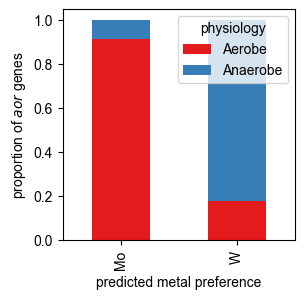

In [129]:
pd.crosstab(aorGTDB_ncbi_sub['predict'],aorGTDB_ncbi_sub['physiology'])

X = pd.crosstab(aorGTDB_ncbi_sub['predict'],aorGTDB_ncbi_sub['physiology'])
Xn = X.apply(lambda x: x/x.sum(),axis=1)

Xn.plot(kind='bar', stacked=True, color=sns.color_palette(palette='Set1',n_colors=2),figsize=(3,3))
plt.ylabel("proportion of $aor$ genes")
plt.xlabel("predicted metal preference")
plt.savefig("AOR.predictedPreference.OxygenTolerance.svg")


In [27]:
fes_cof = pd.read_csv("../data/pterin-binding-gtdb/aor.ferredoxin.predictions.csv",index_col=0)
fes_cof.columns = ["P(!Ferredoxin)", "P(Ferredoxin)"]
aorGTDB_fesR = aorGTDB.join(fes_cof)
aorGTDB_fesR["logP"] = aorGTDB_fesR["P(!Ferredoxin)"].apply(np.log10)

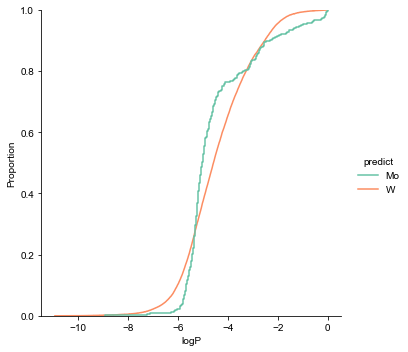

In [61]:
#sns.displot(x="P(!Ferredoxin)",data=aorGTDB_fesR.sort_values("predict"),kind="ecdf",hue="predict",palette="Set2")
#plt.xscale("log")
sns.displot(x="logP",data=aorGTDB_fesR.sort_values("predict"),kind="ecdf",hue="predict",palette="Set2")

In [60]:
aorGTDB_fesR["logP"] = aorGTDB_fesR["P(!Ferredoxin)"].apply(np.log10)

In [50]:
aorGTDB_fesR["pN"] = aorGTDB_fesR["P(Ferredoxin)"] < 0.9

Text(0.5, 0, 'predicted metal preference')

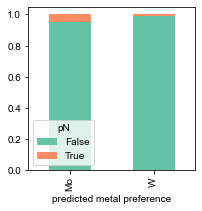

In [55]:

X = pd.crosstab(aorGTDB_fesR['predict'],aorGTDB_fesR['pN'])
Xn = X.apply(lambda x: x/x.sum(),axis=1)

Xn.plot(kind='bar', stacked=True, color=sns.color_palette(palette='Set2',n_colors=2),figsize=(3,3))
#plt.ylabel("proportion of $aor$ genes")
plt.xlabel("predicted metal preference")


In [65]:
aorColors = aorGTDB_ncbi_sub[["gene_id","predict"]]

mo_color = to_hex(sns.palettes.color_palette("Set2")[0])
w_color = to_hex(sns.palettes.color_palette("Set2")[1])
cmap = {}
cmap["Mo"] =mo_color
cmap["W"] =w_color
aorColors["color"] = aorColors["predict"].apply(lambda x: cmap[x])

/var/folders/17/58pxvfhj0gb_wz2nzgrzc6pc0000gn/T/ipykernel_4617/1395403461.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aorColors["color"] = aorColors["predict"].apply(lambda x: cmap[x])


In [36]:
aorColors.set_index('gene_id')[['color']].to_csv("../data/aor/aor.physio.seqColors.l1Reg.18Feb2023.csv")

In [83]:
aorColors

,gene_id,predict,color
24,NZ_CP066369_1_1113,W,#fc8d62
24,NZ_CP066370_1_1106,W,#fc8d62
52,NZ_CP012159_1_5949,W,#fc8d62
274,AP017920_1_1018,W,#fc8d62
274,AP017920_1_1216,W,#fc8d62
...,...,...,...
1750597,NZ_RJVI01000002_1_645,W,#fc8d62
1773489,NZ_SLZW01000003_1_102,W,#fc8d62
1835254,NZ_CP007501_1_181,W,#fc8d62
1894989,NZ_RKRE01000001_1_643,W,#fc8d62


In [271]:
#29/(28+109)
#239 / (239 + 912)

In [66]:
seqs = SeqIO.to_dict(SeqIO.parse("../data/pterin-binding-gtdb/seqs.fa","fasta"))
aor_genes = aorGTDB.index.tolist()
gene_list = [x.replace('.',"_") for x in list(seqs)]
z = pd.DataFrame({'gene':gene_list,"gkey": list(seqs)})
gene_list = z[z.gene.isin(aor_genes)].gkey.tolist()
seqs = {x:y for x,y in seqs.items() if x in gene_list}

In [74]:
mo_aors = aorColors[aorColors.predict == "Mo"].gene_id.tolist()

In [75]:
seqs_mo_aors = {x:y for x,y in seqs.items() if x.replace(".","_") in mo_aors}

In [82]:
print(seqs_mo_aors[list(seqs_mo_aors)[1]].seq)

MGIRGKIEQLSLRMHDTPQYQTQGAVLFVDLERREHFSRYLPLNVLHTFLTGRGANMYLLYNLMADGLEPLDPGIPLIFGSGALTGSVPTATRGNVSSISPESHAILDCSCGDAFPTYLKQHGYDHIVLYGQSPELTLLQISHREVIFHDAAGYRGMDNGDLTHAVEKDFSCTERKNMAMARITNAGENMVLCSGIMGGVKAIYARGGAGAKMGSLKLKAIMVLGSPDAPVLSVKFKENNRDIAQKILSTSVIKNALKTVGTPFLYKPSRILCAMGTKNNQETSWSDSLDADNFDAYRPGMDGCLKCPVRCRPLNDLTPEGKGGWGADALKGLTGNASYDRGQADVGHQKEKTYKGIHGDGVYDRYDKGDGPEYVTLQKMGPMIGIREPEQVLRLNNILNDLGLDSASTGSAISWAMELYQRGIITEKETGGLDLTWGNYQSIEQLLFMTARREGFGDVIADSGRAVERGKYPREALEYRMAVKGLFQSDPHDSRILKGFALGLAVATRGMDHLRNRPTLEINARINDNPQLKAELYGGVVAPAPNSYDGKEYAVRACENMYAVGDAVGMCRFSTKLFNSASTAGYEDFASQLGELTGEKFTPEQMNDIGSNINGIERLINARLGLTSQDDTLPERWFEEEISVGPFKGEKIDRVQFEALKARFYDISGLNTAGVPTVARHEKLAKVVTGFAVRVELPRELVGAPEGAVIVDQQVSSVSDLREALKVRLRHAGHQLEDKSLVVSVNGEMILSNEKDSTINNGDELAVFPLLGGG*


In [163]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [197]:
protein_features = {'seq':[],"length":[],"charge_at_pH7": [], "flexibility": [], "isoelectric_point":[],"aromaticity":[],"hydropathy":[]}
aas =[]

for seq,seqStruct in seqs.items():
    i = str(seqStruct.seq).replace("X","G")[0:-1]
    pa = ProteinAnalysis(i)
    aas.append(pd.DataFrame(pd.Series(pa.get_amino_acids_percent()),columns=[seq]))
    protein_features['seq'].append(seq)
    protein_features['length'].append(pa.length)
    protein_features['charge_at_pH7'].append(pa.charge_at_pH(7))
    protein_features['flexibility'].append(pa.flexibility())
    protein_features['isoelectric_point'].append(pa.isoelectric_point())
    protein_features['aromaticity'].append(pa.aromaticity())
    protein_features['hydropathy'].append(pa.gravy())


In [198]:
protein_features = pd.DataFrame(protein_features)
aas = pd.concat(aas,axis=1)

In [206]:
aas = aas.T
aas['gene']=[x.replace(".","_") for x in aas.index.tolist()]
aas.set_index("gene",inplace=True)
aas = aas.join(aorGTDB)

In [210]:
protein_features['seq']=[x.replace(".","_") for x in protein_features.seq.tolist()]
protein_features.set_index("seq",inplace=True)
protein_features = protein_features.join(aorGTDB)


<AxesSubplot:xlabel='predict', ylabel='length'>

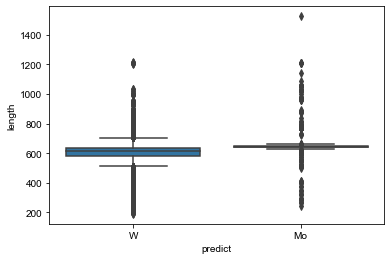

In [212]:
sns.boxplot(x='predict',y="length",data=protein_features)

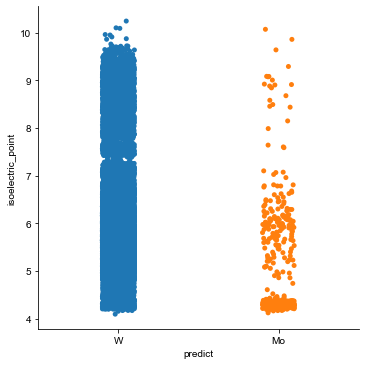

In [215]:
sns.catplot(x='predict',y="isoelectric_point",data=protein_features)

In [223]:
protein_features.join(aas[])

['length',
 'charge_at_pH7',
 'flexibility',
 'isoelectric_point',
 'aromaticity',
 'hydropathy',
 'predict',
 'KO',
 'genome']

In [220]:
from scipy.stats import mannwhitneyu

In [225]:
feature = "isoelectric_point"
x = protein_features[protein_features['predict'].isin(['W'])][feature].values
y = protein_features[protein_features['predict'].isin(['Mo'])][feature].values                
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=6722183.0, pvalue=9.195049785764502e-65)

In [230]:
amino_acids = [x for x in list(aas) if len(x)<2]

In [252]:
pvals = []
stats = []
fc = []
for a in amino_acids:
    x = aas[aas['predict'].isin(['W'])][a].values
    y = aas[aas['predict'].isin(['Mo'])][a].values                
    stat,pval = mannwhitneyu(x,y)
    stats.append(stat)
    pvals.append(pval)
    fc.append(np.log10(np.mean(y) / np.mean(x)))
    
astats = pd.DataFrame({"amnio_acid":amino_acids,"ustat":stats,"pvals":pvals,"fc":fc})

In [253]:
astats.sort_values("pvals")

,amnio_acid,ustat,pvals,fc
7,I,7053103.5,1.061765e-84,-0.112977
2,D,2010517.5,3.374434e-78,0.131033
4,F,6918188.5,3.043278e-76,-0.117202
8,K,6641569.5,2.557360e-60,-0.121099
10,M,2468474.0,1.667233e-52,0.086481
9,L,6300396.5,2.683096e-43,-0.048018
3,E,2703795.5,2.497343e-41,0.090707
12,P,5821658.0,2.768725e-24,-0.030513
18,W,5814923.0,4.669110e-24,-0.096553
1,C,5670498.5,1.851019e-19,-0.051571


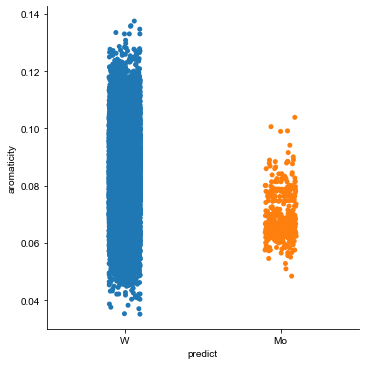

In [219]:
sns.catplot(x='predict',y="aromaticity",data=protein_features)

In [216]:
list(protein_features)

['length',
 'charge_at_pH7',
 'flexibility',
 'isoelectric_point',
 'aromaticity',
 'hydropathy',
 'predict',
 'KO',
 'genome']

In [138]:
X = pd.crosstab(aorGTDB_ncbi_sub['predict'],aorGTDB_ncbi_sub['physiology'])
Xn = X.apply(lambda x: x/x.sum(),axis=1)

In [ ]:
44/()

In [140]:
fisher_exact(X)

(50.16591928251121, 3.7751040558031215e-27)

In [145]:
len(aorGTDB[aorGTDB.predict == 'Mo']) / len(aorGTDB)

0.01677535610090956

Text(0.5, 0, 'predicted metal preference')

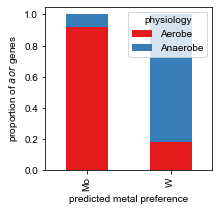

In [59]:
#plt.figure(figsize=(3,3))
Xn.plot(kind='bar', stacked=True, color=sns.color_palette(palette='Set1',n_colors=2),figsize=(3,3))
plt.ylabel("proportion of $aor$ genes")
plt.xlabel("predicted metal preference")
plt.savefig("AOR.predictedPreference.")

In [12]:
cof = pd.read_csv("aor.CofactorPredictions.csv")

In [13]:
cof

,gene,F420,FADH2,FMN,Ferrecytochome,Ferredoxins,Flavodoxin,Flavoprotein,Formaldehyde_Methanol,Glutaredoxin,Glutathione,H2,H2O2_2H2O,NAD_NADH,NADP_NADPH,O2_H2O2,Quinone,Succinate_Fumarate,Thioredoxin
0,ADZZ01000072_1_3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,ADZZ01000330_1_31,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,ADZZ01000712_1_1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,AGIG01000028_1_204,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,AKCV02000026_1_331,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23303,WYEN01000030_1_2,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
23304,WYEN01000038_1_6,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
23305,WYEN01000096_1_4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
23306,WYEN01000106_1_2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [274]:
#cof.set_index("gene").sum()

In [16]:
aorGTDB_c = aorGTDB.join(cof.set_index("gene"))

In [17]:
#aorGTDB_c[['predict',"Ferredoxins"]]
c = "Ferredoxins"
pd.crosstab(aorGTDB_c['predict'],aorGTDB_c[c])


Ferredoxins,False,True
predict,,
Mo,13,375
W,38,22882


In [277]:
(14/(377+14))

0.03580562659846547

In [70]:
(14/(377+14)) / (37/(37+22880))

22.177230939379275

In [80]:
c = "Quinone"
pd.crosstab(aorGTDB_c['predict'],aorGTDB_c[c])


Quinone,False,True
predict,,
Mo,377,14
W,22622,295


In [18]:
from scipy.stats import fisher_exact

In [19]:
#coenzymes = list(cof.set_index("gene"))
coenzymes = cof.set_index("gene").sum()
coenzymes = coenzymes[coenzymes > 50].index.tolist()
fstats = {'coenzyme':[],'fstat':[],"pval":[],"Mo_fraction":[],"W_fraction":[],"contigency":[]}
for c in coenzymes:
    X = pd.crosstab(aorGTDB_c['predict'],aorGTDB_c[c])
    if X.shape == (2,2):
        stat,pval = fisher_exact(X.values)
        fstats['coenzyme'].append(c)
        fstats['fstat'].append(stat)
        fstats['pval'].append(pval)
        fstats['contigency'].append(X)
        fstats['Mo_fraction'].append(X.loc["Mo"].loc[True] / (X.loc["Mo"].loc[True] +X.loc["Mo"].loc[False]))
        fstats['W_fraction'].append(X.loc["W"].loc[True] / (X.loc["W"].loc[True] +X.loc["W"].loc[False]))

In [20]:
fstats = pd.DataFrame(fstats)

In [21]:
fstats.iloc[0].contigency

Ferredoxins,False,True
predict,,
Mo,13,375
W,38,22882


In [22]:
fstats

,coenzyme,fstat,pval,Mo_fraction,W_fraction,contigency
0,Ferredoxins,20.874807,1.659269e-12,0.966495,0.998342,Ferredoxins False True predict ...
1,NAD_NADH,0.961869,7.906986e-01,0.095361,0.092059,NAD_NADH False True predict ...
2,NADP_NADPH,0.116340,1.076419e-05,0.020619,0.002443,NADP_NADPH False True predict ...
3,O2_H2O2,1.043375,1.000000e+00,0.012887,0.013438,O2_H2O2 False True predict Mo...
4,Quinone,0.348319,7.314073e-04,0.036082,0.012871,Quinone False True predict Mo...


In [22]:
fstats['Mo_enrich'] = np.log2(fstats['Mo_fraction'] / fstats['W_fraction'])

In [23]:
fstats['p-value (log10)'] = fstats['pval'].apply(lambda x: -np.log10(x))

<AxesSubplot:xlabel='Mo_enrich', ylabel='p-value (log10)'>

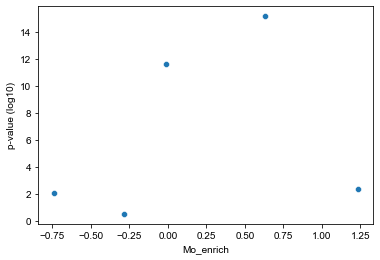

In [284]:
sns.scatterplot(x='Mo_enrich',y="p-value (log10)",data=fstats)

In [24]:
fstats

,coenzyme,fstat,pval,Mo_fraction,W_fraction,contigency,Mo_enrich,p-value (log10)
0,Ferredoxins,7.990046,2.329685e-12,0.990976,0.998862,Ferredoxins False True predict ...,-0.011434,11.632703
1,NAD_NADH,0.611450,6.883491e-16,0.133097,0.085820,NAD_NADH False True predict ...,0.633087,15.162191
2,NADP_NADPH,0.423250,4.625033e-03,0.005479,0.002326,NADP_NADPH False True predict ...,1.235851,2.334885
3,O2_H2O2,1.222898,3.142140e-01,0.011279,0.013759,O2_H2O2 False True predict Mo...,-0.286681,0.502774
4,Quinone,1.681155,8.840578e-03,0.008379,0.014006,Quinone False True predict Mo...,-0.741242,2.053519
